# Homework 2

Name: Jesse Yan

Email: jesseyan@uchicago.edu

Course: Applied Algorithmic Trading

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
# import quandl # Not used, as my account got deactivated, so I requested a day pass and downloaded a CSV from WRDS
import functools
import seaborn as sns
import plotnine as p9
import os
import datetime
from typing import Tuple, List, Dict
import statsmodels.api as sm

## Investment Hypothesis and Goals

The hypothesis we aim to test is the correlation between UBER and LYFT, both ride-sharing service companies, and UBER and DASH, both food-delivery companies. Our investment objective is to successfully pairs-trade them, and outperform an index of hedge funds (HFRI) on a variety of metrics (raw return, Sharpe, etc.). HFRI is not investible, so for my benchmark, we will use the HDG ETF, which acts as a proxy (imitates MLFM-ES, an exchange series based off MLFM, a factor decomposition of HFRI by Merrill Lynch). 

Our investment universe are the three stocks of Uber, Lyft, and DoorDash. Returns are defined as percentage of initial investment gained after investment in this strategy; none of these stocks pay a dividend, but HDG does, so in the comparison of returns, dividends will be ignored for simplicity. Rebalancing will occur daily. We will assume only bid-ask spread in transaction costs for simplicity as well. In future analysis, dividends will be incorporated in the return calculations, and a minor 1bps of notional cost (zeta) will be assumed as well to capture market impact in a highly liquid environment. We will test these companies from IPO, since the earliest IPO was in April 2019.

LYFT, UBER, and DASH are all highly liquid stocks, but when backtesting against the benchmark HDG, it is important to be reasonable and not exceed the volume traded on that day. Otherwise, there will be high market impact. We will address this by assuming we can trade 1% of the lowest dollar-volume, with no constraints on capital. We will abide by the constraint to use a whole number of shares (no fractional trading).

Another major assumption is that we are a proprietary trading firm trading with our own money, and we refuse to borrow money. Leverage (using risk-free rate plus 100 bps or so) will be assumed in future analysis, but for now, when we are short, we will assume no cost to borrow for simplicity.

In addition, we implement stop-losses, but we have no time-out period after reaching them, which is not the greatest risk management, but it is something to adapt in the future.

## Portfolio Construction and Rebalancing

We construct the portfolio using historical data pulled from the CRSP database from WRDS. We first load the data from the CSV.

In [2]:
data = pd.read_csv('crsp_data.csv')
data['date'] = pd.to_datetime(data['date'])
data = data[data['PRC'] > 0].copy()
data = data.drop_duplicates(subset=['date', 'TICKER']).copy()
data = data.sort_values(by=['TICKER', 'date']).reset_index(drop=True)
data.head()

,PERMNO,date,TICKER,COMNAM,DCLRDT,PAYDT,RCRDDT,DIVAMT,FACPR,FACSHR,...,PRC,VOL,BID,ASK,SHROUT,CFACPR,CFACSHR,OPENPRC,NUMTRD,sprtrn
0,20189,2020-12-09,DASH,DOORDASH INC,NaN,NaN,NaN,NaN,NaN,NaN,...,189.50999,25373661,189.00,189.50000,286343,1,1,182.00000,NaN,-0.007949
1,20189,2020-12-10,DASH,DOORDASH INC,NaN,NaN,NaN,NaN,NaN,NaN,...,186.00000,9307612,186.00,186.00999,286343,1,1,179.71001,NaN,-0.001285
2,20189,2020-12-11,DASH,DOORDASH INC,NaN,NaN,NaN,NaN,NaN,NaN,...,175.00000,4760590,174.50,175.00000,286343,1,1,176.52000,NaN,-0.001265
3,20189,2020-12-14,DASH,DOORDASH INC,NaN,NaN,NaN,NaN,NaN,NaN,...,160.00000,7859600,159.05,159.56000,286343,1,1,169.10001,NaN,-0.004359
4,20189,2020-12-15,DASH,DOORDASH INC,NaN,NaN,NaN,NaN,NaN,NaN,...,158.89000,5017013,158.88,159.00000,286343,1,1,157.10001,NaN,0.012921


Let's analyze dollar-volume first to determine the maximum we can trade.

In [3]:
# Create a DataFrame with a unique index of all dates
dollar_volume = pd.DataFrame(index=np.sort(data['date'].unique()))

# Calculate dollar volume for each ticker
for ticker in data['TICKER'].unique():
    ticker_data = data[data['TICKER'] == ticker]
    ticker_data = ticker_data.set_index('date')
    ticker_dollar_volume = ticker_data['PRC'] * ticker_data['VOL'] * 0.01
    dollar_volume[ticker] = ticker_dollar_volume.reindex(dollar_volume.index, fill_value=0)
    dollar_volume[f'{ticker}_rollDV'] = dollar_volume[ticker].rolling(window=15).median() # Use this in volume calculations

In [4]:
dollar_volume.mean()

DASH           2.939705e+06
DASH_rollDV    2.480200e+06
HDG            2.135067e+03
HDG_rollDV     1.207323e+03
LYFT           2.653551e+06
LYFT_rollDV    2.266652e+06
UBER           9.332941e+06
UBER_rollDV    8.122468e+06
dtype: float64

We can see that Uber has the highest liquidity, followed by DoorDash, then Lyft. However, due to missing volume data near IPO, we will go with the older member of the pair in each analysis, although with a slight modifier for Uber to account for it's higher liquidity than DASH. We optimally want to use the lower-liquidity member as that is the constraining factor.

In order to pairs trade, we must identify which days both compenents of the pairs were available to trade:

In [5]:
uber_ipo = data[data['TICKER'] == 'UBER'].iloc[0].date
uber_ipo

Timestamp('2019-05-10 00:00:00')

In [6]:
lyft_ipo = data[data['TICKER'] == 'LYFT'].iloc[0].date
lyft_ipo

Timestamp('2019-03-29 00:00:00')

In [7]:
dash_ipo = data[data['TICKER'] == 'DASH'].iloc[0].date
dash_ipo

Timestamp('2020-12-09 00:00:00')

Now, we generate the dataframes of the two pairs, using the latest IPO date within each pair.

In [8]:
uber_lyft = data[(data['TICKER'].isin(['UBER', 'LYFT'])) & (data['date'] >= uber_ipo)].copy().reset_index(drop=True)
uber_lyft = uber_lyft.pivot(index='date', columns='TICKER', values=['BID', 'ASK'])
uber_lyft.columns = ['_'.join(col) for col in uber_lyft.columns]
start_date, end_date = uber_lyft.index.min(), uber_lyft.index.max()
filtered_dollar_volume = dollar_volume.loc[start_date:end_date]
uber_lyft['N'] = filtered_dollar_volume['LYFT_rollDV'].reindex(uber_lyft.index)
uber_lyft.head()

,BID_LYFT,BID_UBER,ASK_LYFT,ASK_UBER,N
date,,,,,
2019-05-10,51.00,41.55,51.09,41.56,4.079975e+06
2019-05-13,48.09,37.26,48.16,37.27,4.380840e+06
2019-05-14,50.52,39.95,50.57,39.96,4.079975e+06
2019-05-15,54.06,41.36,54.14,41.37,4.274023e+06
2019-05-16,55.56,42.93,55.62,42.94,4.274023e+06


In [9]:
uber_dash = data[(data['TICKER'].isin(['UBER', 'DASH'])) & (data['date'] >= dash_ipo)].copy().reset_index(drop=True)
uber_dash = uber_dash.pivot(index='date', columns='TICKER', values=['BID', 'ASK'])
uber_dash.columns = ['_'.join(col) for col in uber_dash.columns]
start_date, end_date = uber_dash.index.min(), uber_dash.index.max()
filtered_dollar_volume = dollar_volume.loc[start_date:end_date]
uber_dash['N'] = filtered_dollar_volume['UBER_rollDV'].reindex(uber_dash.index) * 0.35
uber_dash.head()

,BID_DASH,BID_UBER,ASK_DASH,ASK_UBER,N
date,,,,,
2020-12-09,189.00,53.77,189.50000,53.78,2.993276e+06
2020-12-10,186.00,54.38,186.00999,54.39,2.993276e+06
2020-12-11,174.50,52.62,175.00000,52.63,3.003136e+06
2020-12-14,159.05,51.45,159.56000,51.46,3.097936e+06
2020-12-15,158.88,50.99,159.00000,51.04,3.124596e+06


Let's take a look at their graphs first:

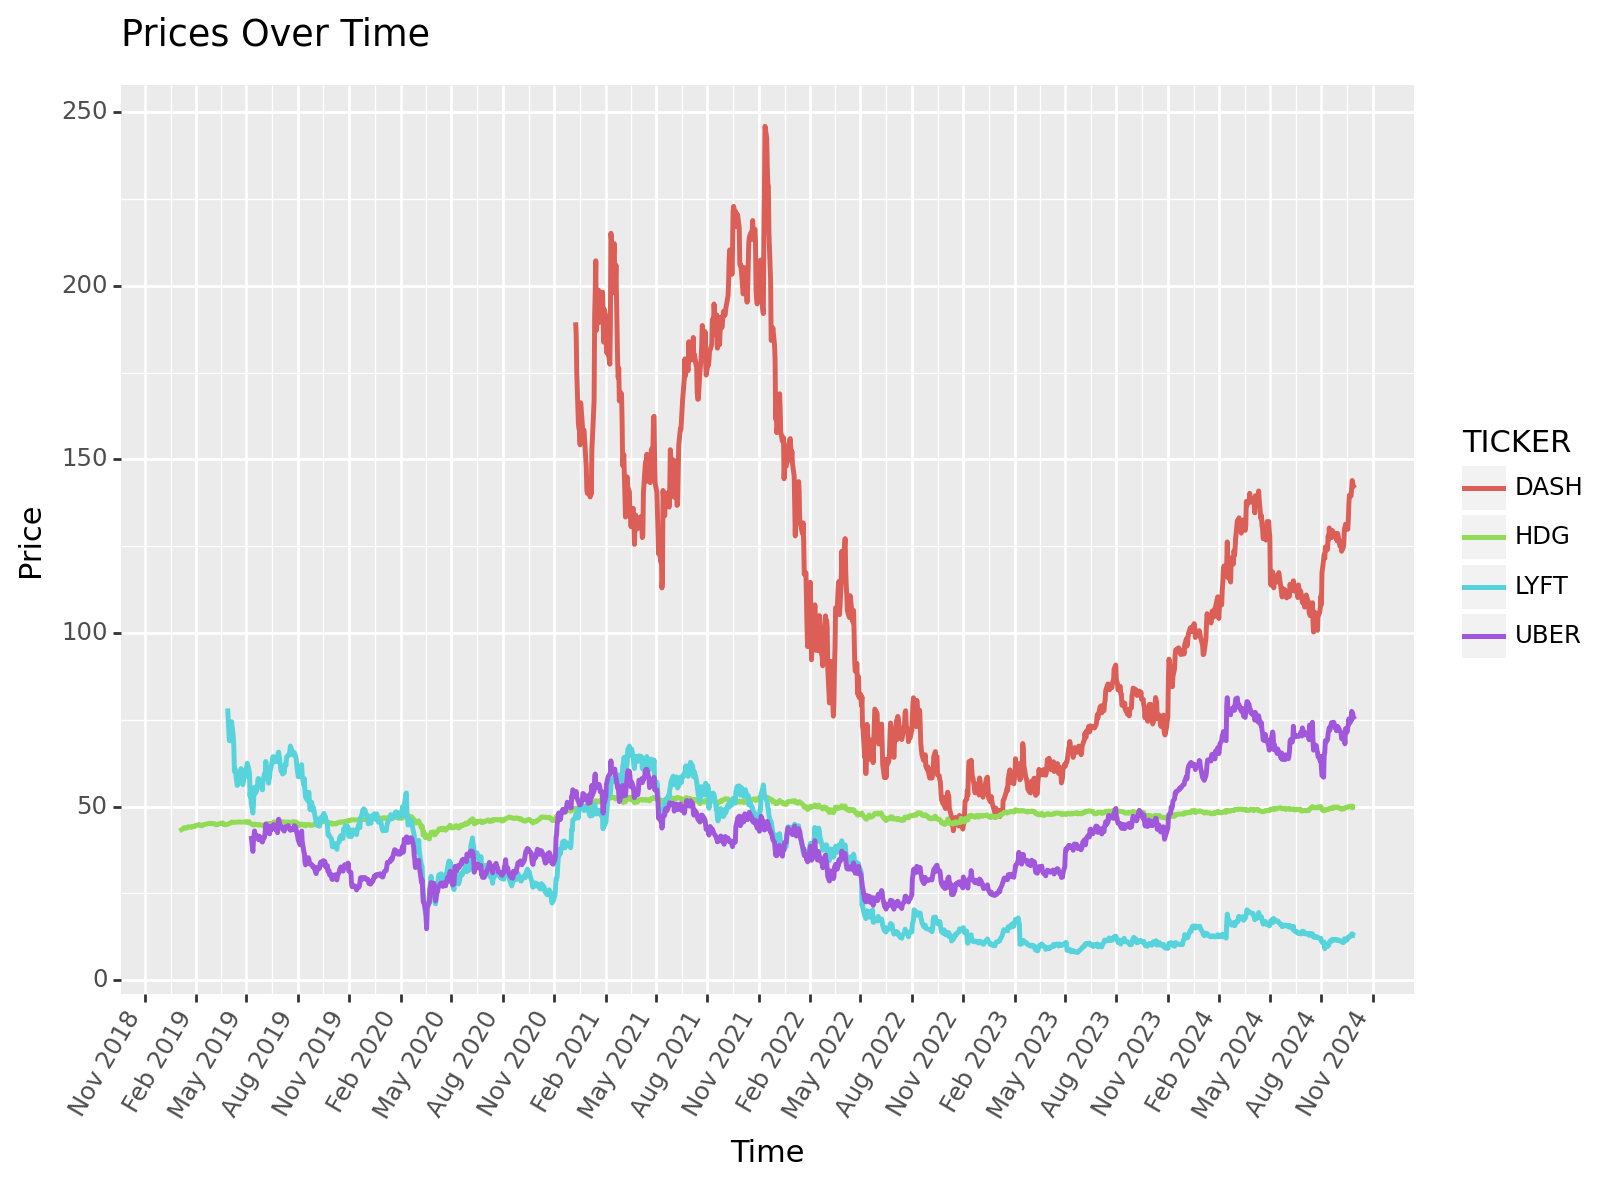

<Figure Size: (800 x 600)>

In [10]:
plot = (
    p9.ggplot(data, p9.aes(x='date', y='PRC', color='TICKER', group='TICKER')) +
    p9.geom_line(size=1) +
    p9.labs(title='Prices Over Time', x='Time', y='Price') +
    p9.scale_x_datetime(date_breaks='3 months', date_labels='%b %Y') +  
    p9.theme(
        axis_text_x=p9.element_text(rotation=60, hjust=1),
        figure_size=(8, 6)
    )
)

plot

### The Algorithm

The actual trading strategy we will use is this:

The strategy looks at the size difference (z) between M-day returns on the stocks in the pair, entering a spread trade where it is short the stock with the higher return and long the stock with the lower return if the size difference exceeds a threshold (g), and closing the trade when the size difference drops below another threshold (j, where j < g). There is also a stop-loss threshold (s), where we stop trading until we see the size difference drops below j again.

Let's set M = 15, g = 0.01, j = 0.001, and s = 0.02 as our hypothesis. We will be using close price as the signal for this, but actual trades will be simulated on bid/ask.

In [11]:
U_L = data[(data['TICKER'].isin(['UBER', 'LYFT', 'HDG'])) & (data['date'] >= uber_ipo)].copy().pivot_table(index='date', columns='TICKER', values='PRC').reset_index()
U_D = data[(data['TICKER'].isin(['UBER', 'DASH', 'HDG'])) & (data['date'] >= dash_ipo)].copy().pivot_table(index='date', columns='TICKER', values='PRC').reset_index()

def calc_diff(df, M):
    for ticker in df.columns[1:3]:  # Skip 'date' and 'HDG' column
        df[f"{ticker}_return"] = df[ticker].pct_change(periods=M)
    df['HDG_return'] = df['HDG'].pct_change()
    df['HDG_cum_return'] = df['HDG'].pct_change().add(1).cumprod().sub(1)
    df['Spread'] = df[df.columns[3]] - df[df.columns[4]]

calc_diff(U_L, 15)
calc_diff(U_D, 20)
U_D[20:25]

TICKER,date,DASH,HDG,UBER,DASH_return,HDG_return,HDG_cum_return,Spread
20,2021-01-08,156.09000,51.165,53.28,-0.176349,0.002693,0.036463,53.456349
21,2021-01-11,167.00000,51.055,54.59,-0.102151,-0.002150,0.034235,54.692151
22,2021-01-12,191.99001,51.270,58.54,0.097086,0.004211,0.038590,58.442914
23,2021-01-13,198.00000,51.260,59.40,0.237500,-0.000195,0.038388,59.162500
24,2021-01-14,207.24001,51.734,56.91,0.304299,0.009247,0.047989,56.605701


C:\Users\axrpo\AppData\Local\Programs\Python\Python39\lib\site-packages\plotnine\geoms\geom_path.py:98: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


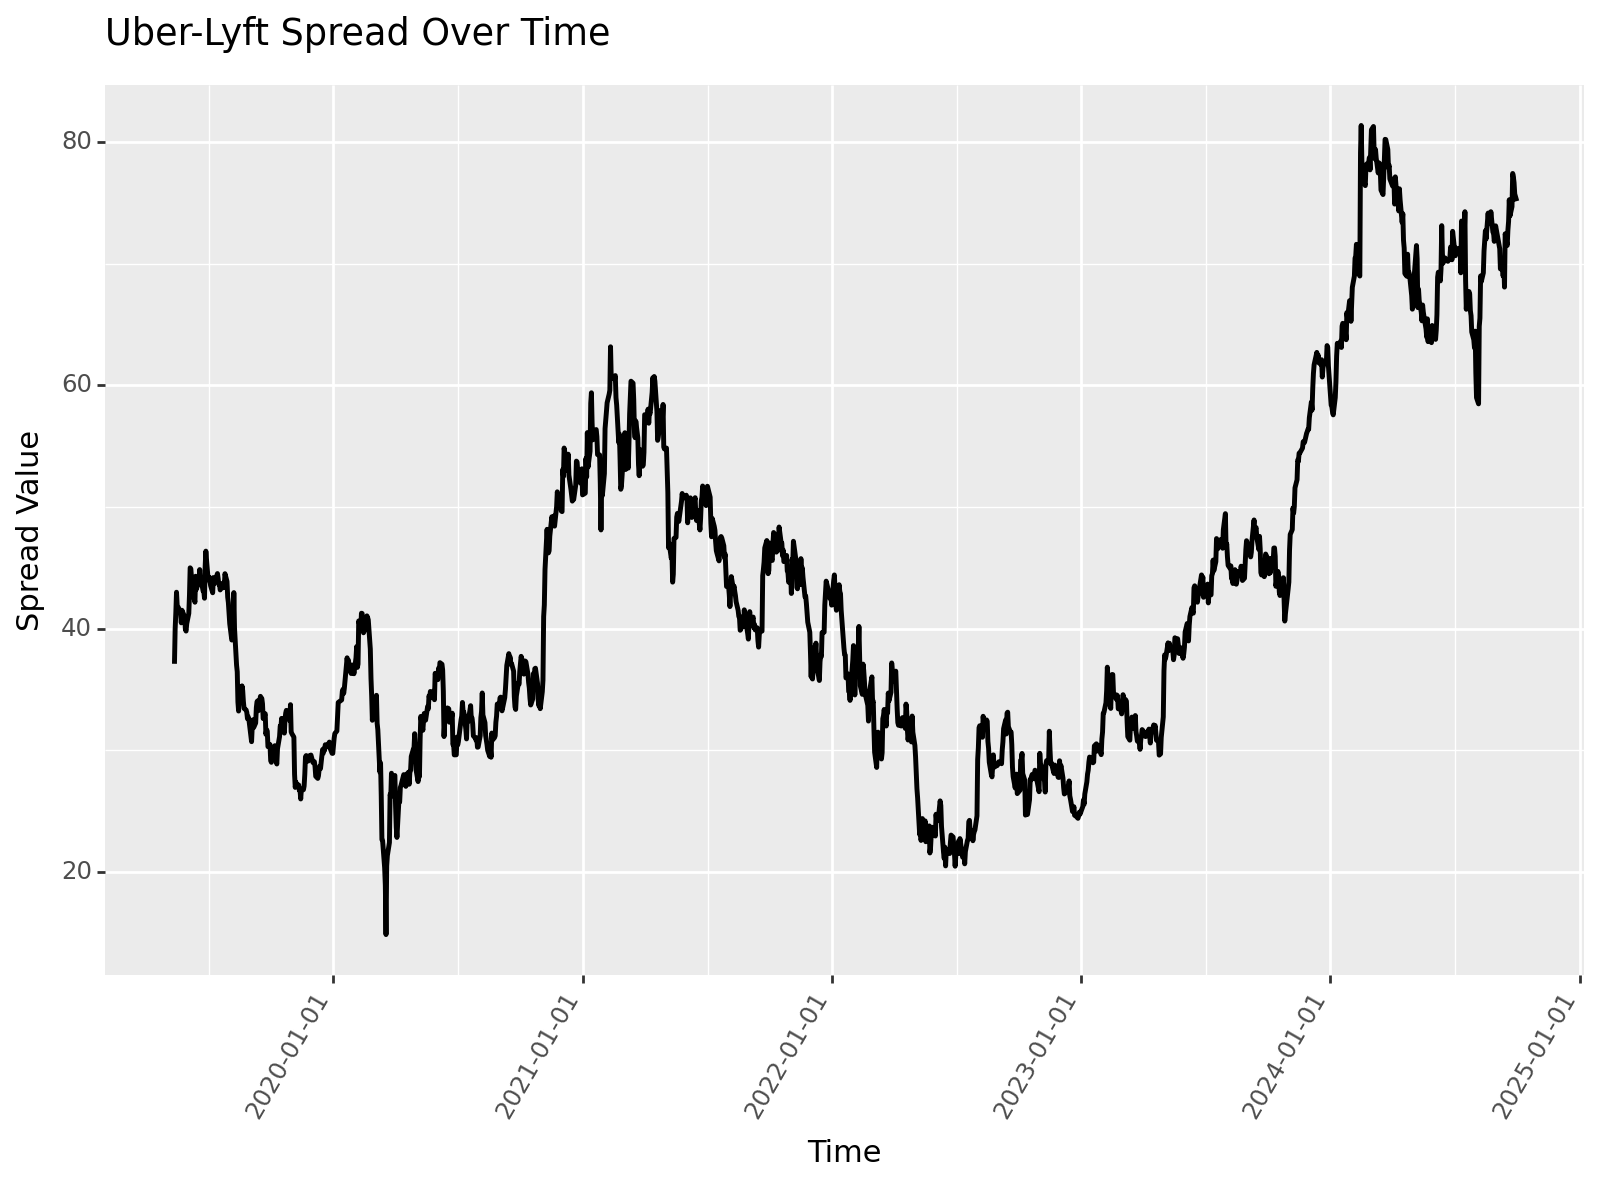

<Figure Size: (800 x 600)>

In [12]:
plot_uber_lyft = (
    p9.ggplot(U_L, p9.aes(x='date')) +
    p9.geom_line(p9.aes(y='Spread'), size=1) +
    p9.labs(title='Uber-Lyft Spread Over Time', x='Time', y='Spread Value') +
    p9.theme(axis_text_x=p9.element_text(rotation=60, hjust=1), figure_size=(8, 6))
)
plot_uber_lyft

C:\Users\axrpo\AppData\Local\Programs\Python\Python39\lib\site-packages\plotnine\geoms\geom_path.py:98: PlotnineWarning: geom_path: Removed 20 rows containing missing values.


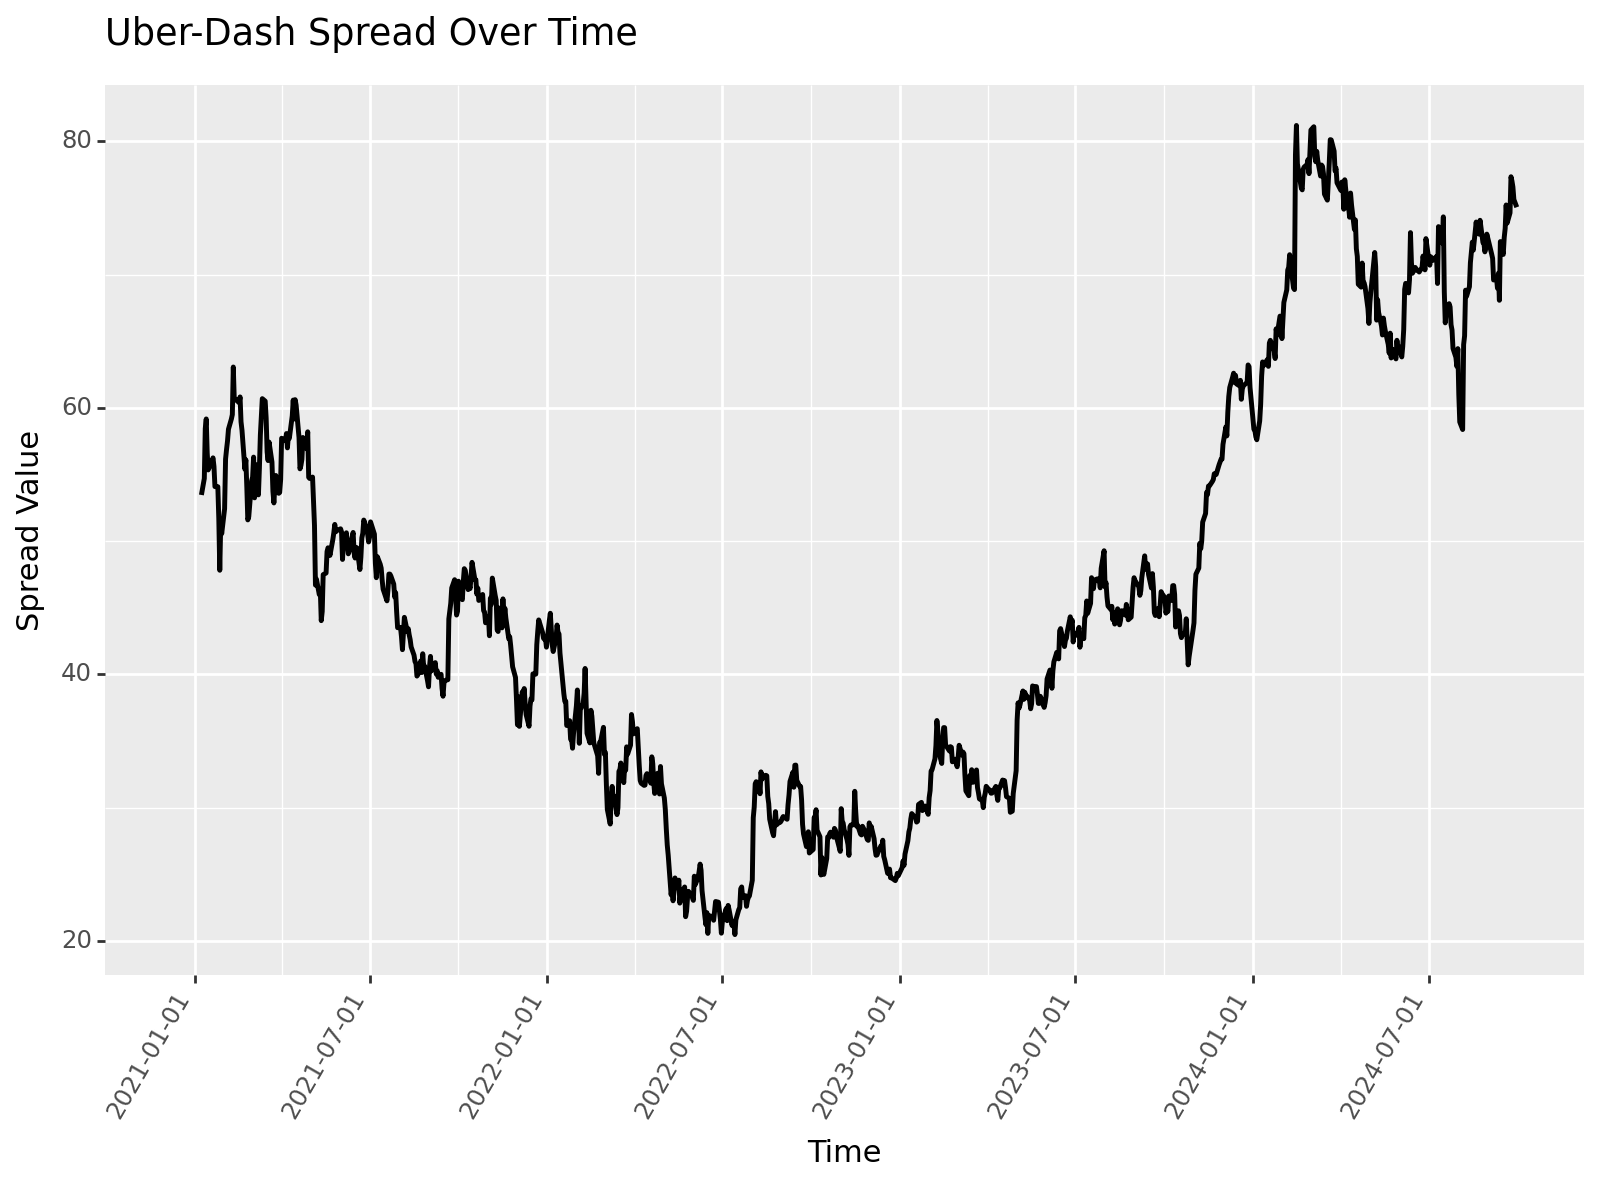

<Figure Size: (800 x 600)>

In [13]:
plot_uber_dash = (
    p9.ggplot(U_D, p9.aes(x='date')) +
    p9.geom_line(p9.aes(y='Spread'), size=1) +
    p9.labs(title='Uber-Dash Spread Over Time', x='Time', y='Spread Value') +
    p9.theme(axis_text_x=p9.element_text(rotation=60, hjust=1), figure_size=(8, 6))
)
plot_uber_dash

Merge the two dataframes together for easier analysis:

In [14]:
uber_dash.reset_index(inplace=True)
uber_lyft.reset_index(inplace=True)
U_D['date'] = pd.to_datetime(U_D['date'])
U_L['date'] = pd.to_datetime(U_L['date'])
uber_dash['date'] = pd.to_datetime(uber_dash['date'])
uber_lyft['date'] = pd.to_datetime(uber_lyft['date'])

# Merge uber_dash with U_D
merged_U_D = pd.merge(U_D, uber_dash, on='date', how='left')

# Merge uber_lyft with U_L
merged_U_L = pd.merge(U_L, uber_lyft, on='date', how='left')

merged_U_D

,date,DASH,HDG,UBER,DASH_return,HDG_return,HDG_cum_return,Spread,BID_DASH,BID_UBER,ASK_DASH,ASK_UBER,N
0,2020-12-09,189.50999,49.3650,53.79,NaN,NaN,NaN,NaN,189.00000,53.77,189.50000,53.78,2.993276e+06
1,2020-12-10,186.00000,49.4900,54.35,NaN,0.002532,0.002532,NaN,186.00000,54.38,186.00999,54.39,2.993276e+06
2,2020-12-11,175.00000,49.4750,52.63,NaN,-0.000303,0.002228,NaN,174.50000,52.62,175.00000,52.63,3.003136e+06
3,2020-12-14,160.00000,49.4500,51.46,NaN,-0.000505,0.001722,NaN,159.05000,51.45,159.56000,51.46,3.097936e+06
4,2020-12-15,158.89000,49.8800,51.00,NaN,0.008696,0.010432,NaN,158.88000,50.99,159.00000,51.04,3.124596e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
952,2024-09-24,141.67999,50.1769,77.44,0.101539,0.002832,0.016447,77.338461,141.67999,77.47,141.69000,77.48,3.600253e+06
953,2024-09-25,143.92999,49.6114,77.14,0.120252,-0.011270,0.004991,77.019748,143.92000,77.16,143.99001,77.17,3.600253e+06
954,2024-09-26,143.02000,49.8750,76.69,0.124725,0.005313,0.010331,76.565275,143.08000,76.66,143.12000,76.68,3.729202e+06
955,2024-09-27,142.23000,49.9039,75.75,0.124081,0.000579,0.010917,75.625919,142.21001,75.76,142.25999,75.77,3.729202e+06


Now, let's code up the trading strategy, along with the backtest to track PnL:

In [15]:
def trading_strategy(ticker1, ticker2, df, M, g, j, s, zeta = 0):
    # Calculate M-day returns
    df[f'{ticker1}_return'] = df[f'{ticker1}'].pct_change(periods=M)
    df[f'{ticker2}_return'] = df[f'{ticker2}'].pct_change(periods=M)

    # Initialize columns
    df['Spread'] = df[f'{ticker1}_return'] - df[f'{ticker2}_return']  # Initialize Spread column
    df['Position to Enter'] = None
    df['Current Position'] = None
    df['Current Trade PnL'] = 0.0
    df['Cumulative PnL'] = 0.0
    df['Gross Traded Cash'] = 0.0

    in_trade = False
    trade_entry_price = {}
    trade_shares = {}
    cumulative_pnl = 0  # Initialize cumulative PnL
    previous_spread = 0  # Initialize previous spread

    for i in range(len(df)):
        if i < M:
            continue

        current_spread = df.loc[i, 'Spread']
        z = abs(current_spread)
        spread_jump = abs(current_spread - previous_spread) > g
        sign_change = current_spread * previous_spread < 0
        df.loc[i, 'Cumulative PnL'] = cumulative_pnl

        if not in_trade:
                if z > g:
                    # Enter trade
                    in_trade = True
                    trade_shares[f'{ticker1}'] = int(df.loc[i, 'N'] / df.loc[i, f'{ticker1}'])
                    trade_shares[f'{ticker2}'] = int(df.loc[i, 'N'] / df.loc[i, f'{ticker2}'])
                    trade_entry_price[f'{ticker1}'] = df.loc[i, f'BID_{ticker1}'] if df.loc[i, f'{ticker1}_return'] > df.loc[i, f'{ticker2}_return'] else df.loc[i, f'ASK_{ticker1}'] 
                    trade_entry_price[f'{ticker2}'] = df.loc[i, f'ASK_{ticker2}'] if df.loc[i, f'{ticker1}_return'] > df.loc[i, f'{ticker2}_return'] else df.loc[i, f'BID_{ticker2}'] 
                    traded_cash = sum(trade_shares[stock] * df.loc[i, stock] for stock in [f'{ticker1}', f'{ticker2}'])
                    df.loc[i, 'Gross Traded Cash'] = traded_cash
                    df.loc[i, 'Current Position'] = df.loc[i - 1, 'Position to Enter']
                    df.loc[i, 'Position to Enter'] = f'Short {ticker1}, Long {ticker2}' if df.loc[i, f'{ticker1}_return'] > df.loc[i, f'{ticker2}_return'] else f'Long {ticker1}, Short {ticker2}'

        elif in_trade:
            # Calculate current trade PnL
            df.loc[i, 'Current Position'] = df.loc[i - 1, 'Current Position'] if df.loc[i - 1, 'Position to Enter'] == 'Stay' else df.loc[i - 1, 'Position to Enter']
            pnl_t1 = (df.loc[i, f'{ticker1}'] - trade_entry_price[f'{ticker1}']) * trade_shares[f'{ticker1}']
            pnl_t2 = (df.loc[i, f'{ticker2}'] - trade_entry_price[f'{ticker2}']) * trade_shares[f'{ticker2}']
            current_trade_pnl = (pnl_t1 - pnl_t2 if df.loc[i, 'Current Position'] == f'Short {ticker1}, Long {ticker2}' 
                                 else (pnl_t2 - pnl_t1 if df.loc[i, 'Current Position'] == f'Long {ticker1}, Short {ticker2}' else 0))
            trading_cost = traded_cash * zeta
            current_trade_pnl -= trading_cost
            df.loc[i, 'Current Trade PnL'] = current_trade_pnl

            # Update Position to Enter and Gross Traded Cash

            df.loc[i, 'Position to Enter'] = 'Stay'
            df.loc[i, 'Gross Traded Cash'] = df.loc[i - 1, 'Gross Traded Cash']
            
            # Exit trade conditions
            if z < j or abs(current_trade_pnl) > s * df.loc[i, 'Gross Traded Cash'] or sign_change or i == max(range(len(df))):
                cumulative_pnl += current_trade_pnl * (1-zeta) - trading_cost
                df.loc[i, 'Cumulative PnL'] = cumulative_pnl
                in_trade = False
                trade_entry_price = {}
                trade_shares = {}
                df.loc[i, 'Position to Enter'] = None
                previous_spread = current_spread  # Update previous spread

                # Check if we should enter a new trade in the reverse position
                if z > g and spread_jump and sign_change:
                    # Enter new trade in the reverse position
                    in_trade = True
                    trade_shares[f'{ticker1}'] = int(df.loc[i, 'N'] / df.loc[i, f'{ticker1}'])
                    trade_shares[f'{ticker2}'] = int(df.loc[i, 'N'] / df.loc[i, f'{ticker2}'])
                    trade_entry_price[f'{ticker1}'] = df.loc[i, f'BID_{ticker1}'] if df.loc[i, f'{ticker1}_return'] > df.loc[i, f'{ticker2}_return'] else df.loc[i, f'ASK_{ticker1}'] 
                    trade_entry_price[f'{ticker2}'] = df.loc[i, f'ASK_{ticker2}'] if df.loc[i, f'{ticker1}_return'] > df.loc[i, f'{ticker2}_return'] else df.loc[i, f'BID_{ticker2}'] 
                    traded_cash = sum(trade_shares[stock] * df.loc[i, stock] for stock in [f'{ticker1}', f'{ticker2}'])
                    df.loc[i, 'Gross Traded Cash'] = traded_cash
                    # Reverse the position based on current returns
                    df.loc[i, 'Position to Enter'] = f'Short {ticker1}, Long {ticker2}' if df.loc[i, f'{ticker1}_return'] > df.loc[i, f'{ticker2}_return'] else f'Long {ticker1}, Short {ticker2}'

    return df

Below is a sample of what trading the 15-day-return spread with an entry threshold of 25%, an exit threshold of 1%, and a stop-loss set at 10% of the gross-traded cash looks like:

In [16]:
trading_strategy('UBER', 'LYFT', merged_U_L, 15, .25, .01, .1, 0)[21:]

,date,HDG,LYFT,UBER,HDG_return,LYFT_return,HDG_cum_return,Spread,BID_LYFT,BID_UBER,ASK_LYFT,ASK_UBER,N,UBER_return,Position to Enter,Current Position,Current Trade PnL,Cumulative PnL,Gross Traded Cash
21,2019-06-11,45.1591,58.07,42.45,0.000946,0.062969,0.001750,-0.042291,58.08,42.48,58.15,42.49,2.120591e+06,0.020678,None,None,0.0,0.00,0.0
22,2019-06-12,45.1266,58.41,42.17,-0.000720,0.052243,0.001029,-0.036098,58.35,42.14,58.42,42.15,2.120591e+06,0.016145,None,None,0.0,0.00,0.0
23,2019-06-13,45.1291,61.21,44.31,0.000055,0.057533,0.001085,0.016649,61.13,44.29,61.21,44.30,1.779634e+06,0.074182,None,None,0.0,0.00,0.0
24,2019-06-14,45.1095,60.96,43.23,-0.000434,0.049045,0.000650,0.019154,60.87,43.22,60.92,43.23,1.641215e+06,0.068199,None,None,0.0,0.00,0.0
25,2019-06-17,45.0850,63.60,43.78,-0.000543,0.113835,0.000106,-0.059150,63.60,43.76,63.70,43.77,1.779634e+06,0.054686,None,None,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1352,2024-09-24,50.1769,13.33,77.44,0.002832,0.174449,0.113059,-0.097248,13.33,77.47,13.34,77.48,1.338497e+06,0.077201,None,None,0.0,-139613.91,0.0
1353,2024-09-25,49.6114,13.35,77.14,-0.011270,0.177249,0.100514,-0.099272,13.35,77.16,13.36,77.17,1.338497e+06,0.077977,None,None,0.0,-139613.91,0.0
1354,2024-09-26,49.8750,13.28,76.69,0.005313,0.180444,0.106362,-0.104094,13.27,76.66,13.28,76.68,1.338497e+06,0.076351,None,None,0.0,-139613.91,0.0
1355,2024-09-27,49.9039,12.84,75.75,0.000579,0.160940,0.107003,-0.072265,12.83,75.76,12.84,75.77,1.338497e+06,0.088675,None,None,0.0,-139613.91,0.0


Now let's try to identify which portfolio with the given parameters performs best for Uber/Lyft and Uber/DoorDash:

In [17]:
M_values = [5, 10, 15, 20]
g_values = [.1, .2, .3]
s_values = [.1, .01, .001]

results = {}
df = merged_U_L.copy()
# Loop over each combination of parameters
for M in M_values:
    for g in g_values:
        j_values = [g * x for x in [.1, .25, .5, .75, .9]]
        for j in j_values:
            for s in s_values:
                # Create a key to represent the current combination
                param_key = f'M={M}, g={g}, j={j}, s={s}'
                
                # Assuming df is your original DataFrame
                # Call the trading strategy function with the current parameters
                result = trading_strategy('UBER', 'LYFT', df, M, g, j, s, 0)['Cumulative PnL'].iloc[1356]
                
                # Store the result in the dictionary
                results[param_key] = result


rows_list = []

# Iterate over each combination of parameters and fetch 'Cumulative PnL'
for M in M_values:
    for g in g_values:
        j_values = [g * x for x in [.1, .25, .5, .75, .9]]
        for j in j_values:
            for s in s_values:
                param_key = f'M={M}, g={g}, j={j}, s={s}'
                if param_key in results:
                    cumulative_pnl = results[param_key]
                    row = {'M': M, 'g': g, 'j': j, 's': s, 'Cumulative PnL': cumulative_pnl}
                    rows_list.append(row)

# Create a DataFrame from the list of rows
results_df = pd.DataFrame(rows_list)

# Optionally, you can set a multi-index for better organization
results_df.set_index(['M', 'g', 'j', 's'], inplace=True)

results_df.loc[results_df['Cumulative PnL'].idxmax()]

Cumulative PnL    1450220.74
Name: (15, 0.1, 0.010000000000000002, 0.1), dtype: float64

In [18]:
M_values = [5, 10, 15, 20]
g_values = [.1, .2, .3]
s_values = [.1, .01, .001]

results = {}
df = merged_U_D.copy()
# Loop over each combination of parameters
for M in M_values:
    for g in g_values:
        j_values = [g * x for x in [.1, .25, .5, .75, .9]]
        for j in j_values:
            for s in s_values:
                # Create a key to represent the current combination
                param_key = f'M={M}, g={g}, j={j}, s={s}'
                
                # Assuming df is your original DataFrame
                # Call the trading strategy function with the current parameters
                result = trading_strategy('UBER', 'DASH', df, M, g, j, s, 0)['Cumulative PnL'].iloc[956]
                
                # Store the result in the dictionary
                results[param_key] = result


rows_list = []

# Iterate over each combination of parameters and fetch 'Cumulative PnL'
for M in M_values:
    for g in g_values:
        j_values = [g * x for x in [.1, .25, .5, .75, .9]]
        for j in j_values:
            for s in s_values:
                param_key = f'M={M}, g={g}, j={j}, s={s}'
                if param_key in results:
                    cumulative_pnl = results[param_key]
                    row = {'M': M, 'g': g, 'j': j, 's': s, 'Cumulative PnL': cumulative_pnl}
                    rows_list.append(row)

# Create a DataFrame from the list of rows
results_df = pd.DataFrame(rows_list)

# Optionally, you can set a multi-index for better organization
results_df.set_index(['M', 'g', 'j', 's'], inplace=True)

results_df.loc[results_df['Cumulative PnL'].idxmax()]

Cumulative PnL    2.075151e+06
Name: (20, 0.1, 0.07500000000000001, 0.01), dtype: float64

## Evaluating Backtesting Results

It's difficult to calculate a % return when you are short and long, especially in this case, as we try to ensure both are equal in magnitude. This results in magnified results, as the net asset value would be near zero. Instead, I propose using the largest cash outlay per dollar-volume, and adding to that the threshold set for stop-loss to imitate a margin requirement. Let's first calculate the best scenarios from above.

In [19]:
best_U_L = trading_strategy('UBER', 'LYFT', merged_U_L, 15, .1, .01, .1, 0)
best_U_L['return'] = best_U_L['Cumulative PnL'] / (max(best_U_L['N']) * (1 + 0.1))
best_U_L

,date,HDG,LYFT,UBER,HDG_return,LYFT_return,HDG_cum_return,Spread,BID_LYFT,BID_UBER,ASK_LYFT,ASK_UBER,N,UBER_return,Position to Enter,Current Position,Current Trade PnL,Cumulative PnL,Gross Traded Cash,return
0,2019-05-10,45.0802,51.09,41.57,NaN,NaN,NaN,NaN,51.00,41.55,51.09,41.56,4.079975e+06,NaN,None,None,0.00,0.00,0.00,0.000000
1,2019-05-13,44.7300,48.15,37.10,-0.007768,NaN,-0.007768,NaN,48.09,37.26,48.16,37.27,4.380840e+06,NaN,None,None,0.00,0.00,0.00,0.000000
2,2019-05-14,44.7596,50.52,39.96,0.000662,NaN,-0.007112,NaN,50.52,39.95,50.57,39.96,4.079975e+06,NaN,None,None,0.00,0.00,0.00,0.000000
3,2019-05-15,44.7700,54.04,41.29,0.000232,NaN,-0.006881,NaN,54.06,41.36,54.14,41.37,4.274023e+06,NaN,None,None,0.00,0.00,0.00,0.000000
4,2019-05-16,45.0042,55.60,43.00,0.005231,NaN,-0.001686,NaN,55.56,42.93,55.62,42.94,4.274023e+06,NaN,None,None,0.00,0.00,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1352,2024-09-24,50.1769,13.33,77.44,0.002832,0.174449,0.113059,-0.097248,13.33,77.47,13.34,77.48,1.338497e+06,0.077201,None,None,0.00,1476102.98,0.00,0.266095
1353,2024-09-25,49.6114,13.35,77.14,-0.011270,0.177249,0.100514,-0.099272,13.35,77.16,13.36,77.17,1.338497e+06,0.077977,None,None,0.00,1476102.98,0.00,0.266095
1354,2024-09-26,49.8750,13.28,76.69,0.005313,0.180444,0.106362,-0.104094,13.27,76.66,13.28,76.68,1.338497e+06,0.076351,"Long UBER, Short LYFT",None,0.00,1476102.98,2676961.77,0.266095
1355,2024-09-27,49.9039,12.84,75.75,0.000579,0.160940,0.107003,-0.072265,12.83,75.76,12.84,75.77,1.338497e+06,0.088675,Stay,"Long UBER, Short LYFT",-27108.41,1476102.98,2676961.77,0.266095


In [20]:
best_U_D = trading_strategy('UBER', 'DASH', merged_U_D, 20, .1, .075, .01, 0)
best_U_D['return'] = best_U_D['Cumulative PnL'] / (max(best_U_D['N']) * (1 + 0.1))
best_U_D[10:]

,date,DASH,HDG,UBER,DASH_return,HDG_return,HDG_cum_return,Spread,BID_DASH,BID_UBER,ASK_DASH,ASK_UBER,N,UBER_return,Position to Enter,Current Position,Current Trade PnL,Cumulative PnL,Gross Traded Cash,return
10,2020-12-23,158.22000,50.0050,53.71,NaN,0.002908,0.012965,NaN,158.22000,53.71,158.23000,53.72,3.488868e+06,NaN,None,None,0.0,0.000000e+00,0.0,0.000000
11,2020-12-24,158.46001,50.0700,52.88,NaN,0.001300,0.014281,NaN,157.57001,52.83,158.34000,52.87,3.488868e+06,NaN,None,None,0.0,0.000000e+00,0.0,0.000000
12,2020-12-28,147.89000,50.1100,51.97,NaN,0.000799,0.015092,NaN,147.88000,51.96,147.89000,51.97,3.459684e+06,NaN,None,None,0.0,0.000000e+00,0.0,0.000000
13,2020-12-29,141.27000,49.9100,52.27,NaN,-0.003991,0.011040,NaN,140.56000,52.26,140.99001,52.27,3.459684e+06,NaN,None,None,0.0,0.000000e+00,0.0,0.000000
14,2020-12-30,140.20000,50.1400,53.15,NaN,0.004608,0.015699,NaN,140.10001,53.14,140.19000,53.15,3.430832e+06,NaN,None,None,0.0,0.000000e+00,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
952,2024-09-24,141.67999,50.1769,77.44,0.101539,0.002832,0.016447,-0.035020,141.67999,77.47,141.69000,77.48,3.600253e+06,0.066520,None,None,0.0,2.075151e+06,0.0,0.283963
953,2024-09-25,143.92999,49.6114,77.14,0.120252,-0.011270,0.004991,-0.057132,143.92000,77.16,143.99001,77.17,3.600253e+06,0.063120,None,None,0.0,2.075151e+06,0.0,0.283963
954,2024-09-26,143.02000,49.8750,76.69,0.124725,0.005313,0.010331,-0.057362,143.08000,76.66,143.12000,76.68,3.729202e+06,0.067363,None,None,0.0,2.075151e+06,0.0,0.283963
955,2024-09-27,142.23000,49.9039,75.75,0.124081,0.000579,0.010917,-0.075493,142.21001,75.76,142.25999,75.77,3.729202e+06,0.048588,None,None,0.0,2.075151e+06,0.0,0.283963


### Total Return

In [21]:
(1 + best_U_L['return'].loc[1356]) ** (1/(len(best_U_L['date'])/252)) - 1

0.04407245430606643

In [22]:
best_U_L['HDG_cum_return'].loc[1356]

0.10605099356258352

In [23]:
(1 + best_U_D['return'].loc[956]) ** (1/(len(best_U_D['date'])/252)) - 1

0.06803212332837671

In [24]:
best_U_D['HDG_cum_return'].loc[956]

0.010047604578138802

As we can see above, we have a total return of \\$1.45MM when pairs-trading Uber-Lyft for a 26.1% return over the ~5 years, and we have a total return of \\$2.08MM when pairs-trading Uber-DoorDash for a 28.2% return over the ~4 years. That comes out to ~4.4% and ~6.8% annualized, respectively. We underperform the benchmark when we pairs-trade Uber-Lyft, but we outperform significantly with Uber-DoorDash.

### Number of Transactions
See the calculation below. It takes 2 transactions to open and 2 transactions to close each position, so we just count the number of positions opened and multiply by 4 to get number of transactions.

In [25]:
count_differ_L = (~best_U_L['Position to Enter'].isin(['Stay', None])).sum() * 4 # (1 long, 1 short to enter; 1 of each to close as well)

print(f"Total number of transactions for UBER-LYFT: {count_differ_L}")

Total number of transactions for UBER-LYFT: 312


In [26]:
count_differ_D = (~best_U_D['Position to Enter'].isin(['Stay', None])).sum() * 4 # (1 long, 1 short to enter; 1 of each to close as well)

print(f"Total number of transactions for UBER-DASH: {count_differ_D}")

Total number of transactions for UBER-DASH: 696


### Average Gain/Loss per Transaction
We divide total return by number of transactions.

In [27]:
best_U_L['Cumulative PnL'].iloc[1356] / count_differ_L

4648.143397435897

In [28]:
best_U_D['Cumulative PnL'].iloc[956] / count_differ_D

2981.5393531609207

### Maximum Drawdown
We can find maximum drawdown by getting the minimum of the cumulative PnL or return. We can see that the maximum drawdown is much higher for UBER/DASH, potentially making the higher return not worth it.

In [29]:
min_cum_L = min(best_U_L['Cumulative PnL'])
min_ret_L = min(best_U_L['return'])
print(f"Minimum Cumulative PnL: {min_cum_L:.2f}, Minimum Return: {min_ret_L:.4f}")

Minimum Cumulative PnL: -234537.49, Minimum Return: -0.0423


In [30]:
min_cum_D = min(best_U_D['Cumulative PnL'])
min_ret_D = min(best_U_D['return'])
print(f"Minimum Cumulative PnL: {min_cum_D:.2f}, Minimum Return: {min_ret_D:.4f}")

Minimum Cumulative PnL: -1360051.81, Minimum Return: -0.1861


### Sharpe Ratio
We assume risk-free rate is zero. We outperform the benchmark with both pairs with the Sharpe ratio.

In [31]:
periodic_returns_L = (1 + best_U_L['return']).pct_change()
mean_return_L = periodic_returns_L.mean() * 252
std_return_L = periodic_returns_L.std() * np.sqrt(252)
sharpe_ratio = mean_return_L / std_return_L
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

Sharpe Ratio: 0.3786


In [32]:
mean_return_HL = best_U_L['HDG_return'].mean() * 252
std_return_HL = best_U_L['HDG_return'].std() * np.sqrt(252)
sharpe_ratio = mean_return_HL / std_return_HL
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

Sharpe Ratio: 0.2667


In [33]:
periodic_returns_D = (1 + best_U_D['return']).pct_change()
mean_return_D = periodic_returns_D.mean()  * 252
std_return_D = periodic_returns_D.std() * np.sqrt(252)
sharpe_ratio = mean_return_D / std_return_D
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

Sharpe Ratio: 0.5618


In [34]:
mean_return_HD = best_U_D['HDG_return'].mean() * 252
std_return_HD = best_U_D['HDG_return'].std() * np.sqrt(252)
sharpe_ratio = mean_return_HD / std_return_HD
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

Sharpe Ratio: 0.0727


### Tracking Error

This shows that our portfolio deviates quite a bit from the benchmark

In [35]:
tracking_error_L = (periodic_returns_L - best_U_L['HDG_return']).std() * np.sqrt(252)
print(f"Tracking Error: {tracking_error_L:.4f}")

Tracking Error: 0.1643


In [36]:
tracking_error_D = (periodic_returns_D - best_U_D['HDG_return']).std() * np.sqrt(252)
print(f"Tracking Error: {tracking_error_D:.4f}")

Tracking Error: 0.1552


### Information Ratio

The IR for the UBER-LYFT pair:

In [37]:
(mean_return_L - mean_return_HL) / tracking_error_L

0.18404177521440168

The IR for the UBER-DASH pair:

In [38]:
(mean_return_D - mean_return_HD) / tracking_error_D

0.4451698278663

These ratios are not the greatest, as they are all less than 0.5. They suggest these pairs-trading strategies have poor risk-adjusted performance, but considering how much they deviated from the benchmark, these values do make sense.

### Treynor Ratio
UBER-LYFT

In [39]:
L_df = pd.DataFrame({'U_L': periodic_returns_L, 'HDG_L': best_U_L['HDG_return']}).dropna()
D_df = pd.DataFrame({'U_D': periodic_returns_D, 'HDG_D': best_U_L['HDG_return']}).dropna()



X_L = sm.add_constant(L_df['HDG_L'])
y_L = L_df['U_L']

model_L = sm.OLS(y_L, X_L).fit()

beta_L = model_L.params.iloc[1]
alpha_L = model_L.params.iloc[0]

mean_return_L / beta_L

-0.8235762141751514

UBER-DASH

In [40]:
X_D = sm.add_constant(D_df['HDG_D'])
y_D = D_df['U_D']

model_D = sm.OLS(y_D, X_D).fit()

beta_D = model_D.params.iloc[1]
alpha_D = model_D.params.iloc[0]

mean_return_D / beta_D

-2.393910272011926

Both of these ratios are negative due to the negative Beta, suggesting that perhaps this benchmark was not the best.

### Jensen's Alpha

In [41]:
print(f'UBER-LYFT: {alpha_L:4f}')

UBER-LYFT: 0.000214


In [42]:
print(f'UBER-DASH: {alpha_D:4f}')

UBER-DASH: 0.000299


It seems like there isn't that much alpha with regards to our pairs-trading strategies. By this metric, we should go back to the drawing board

### Graphs

Let's take a look at cumulative returns, in percentage terms, over time.

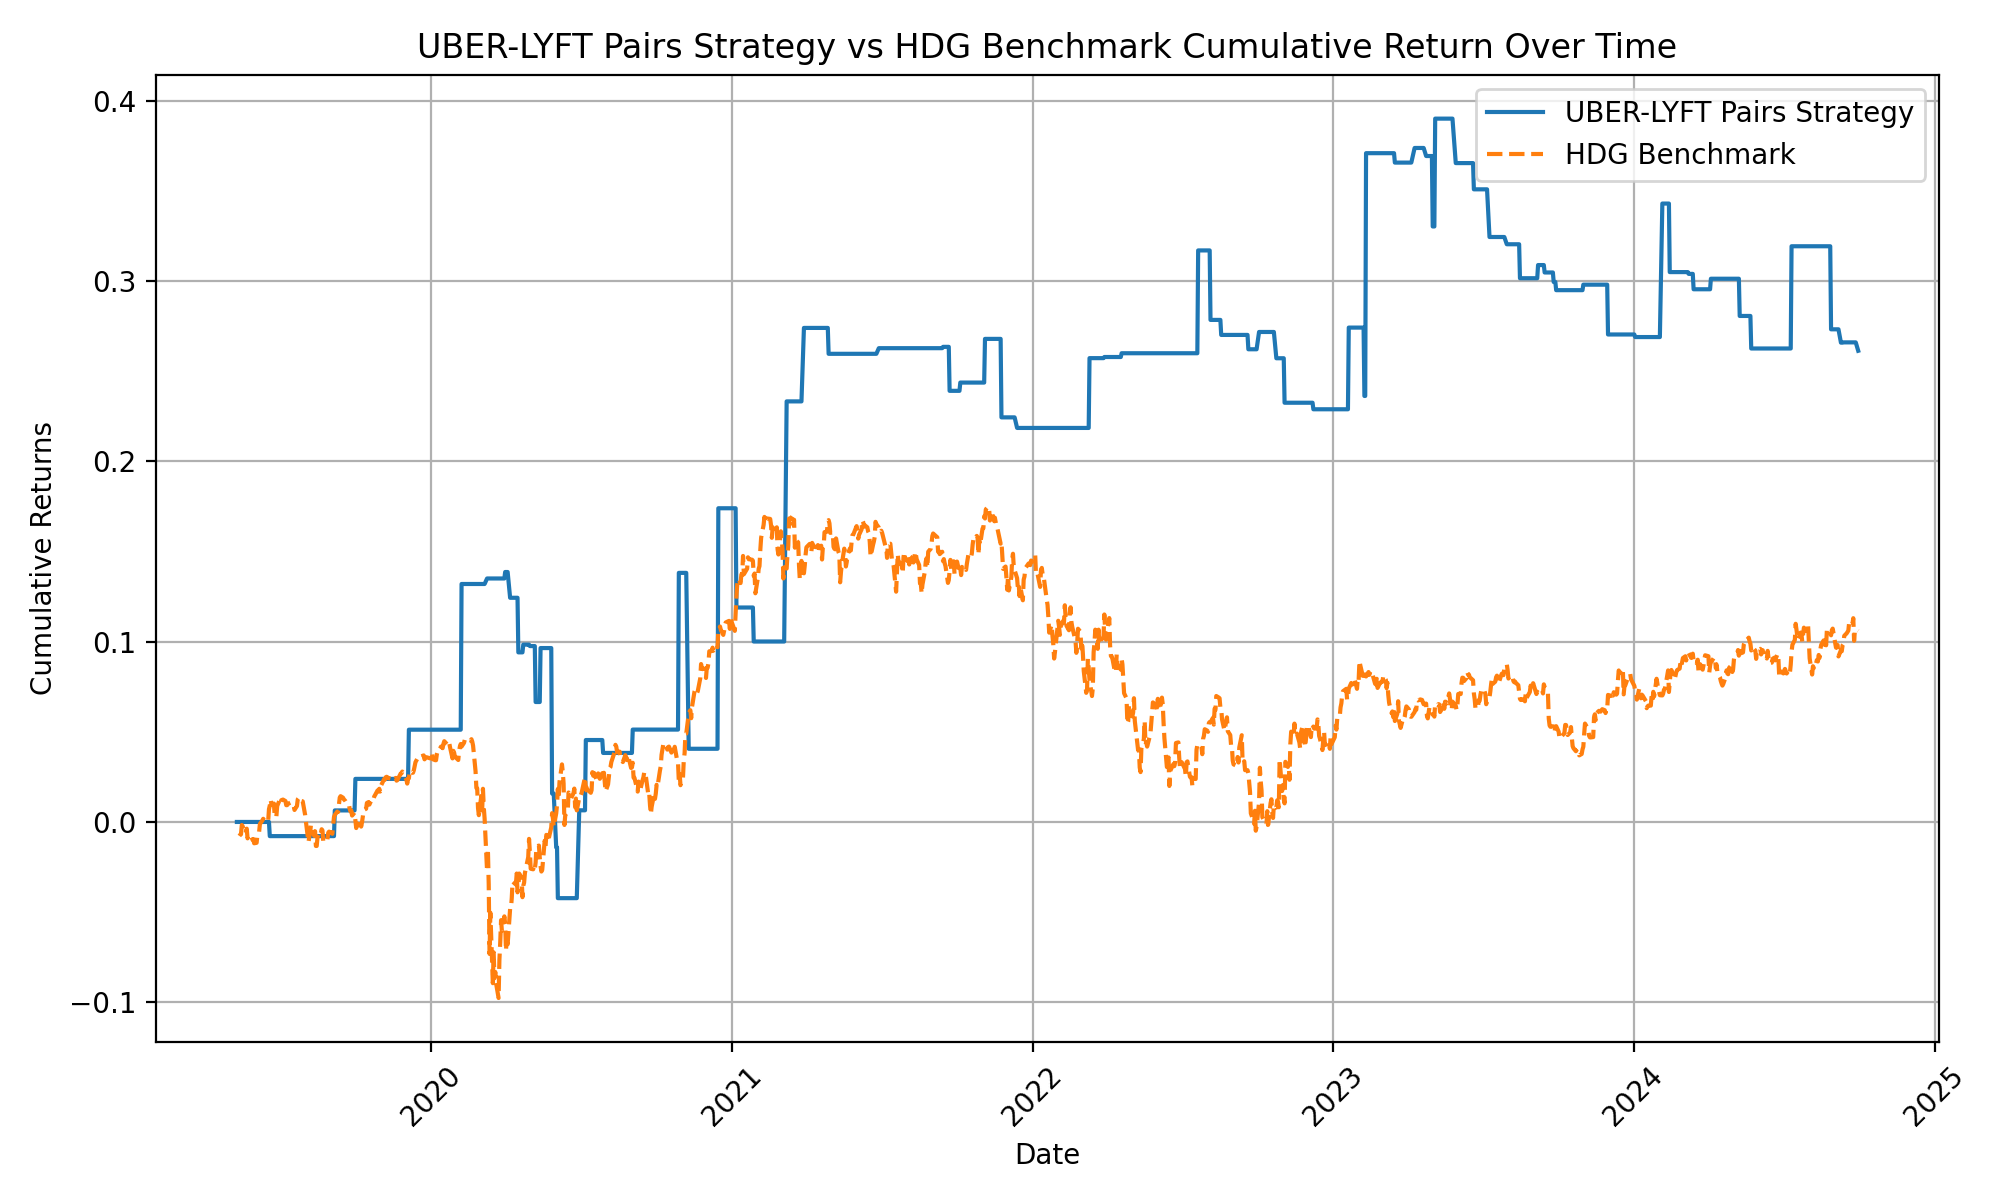

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(best_U_L['date'], best_U_L['return'], label='UBER-LYFT Pairs Strategy')
plt.plot(best_U_L['date'], best_U_L['HDG_cum_return'], label='HDG Benchmark', linestyle='--')
plt.title('UBER-LYFT Pairs Strategy vs HDG Benchmark Cumulative Return Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

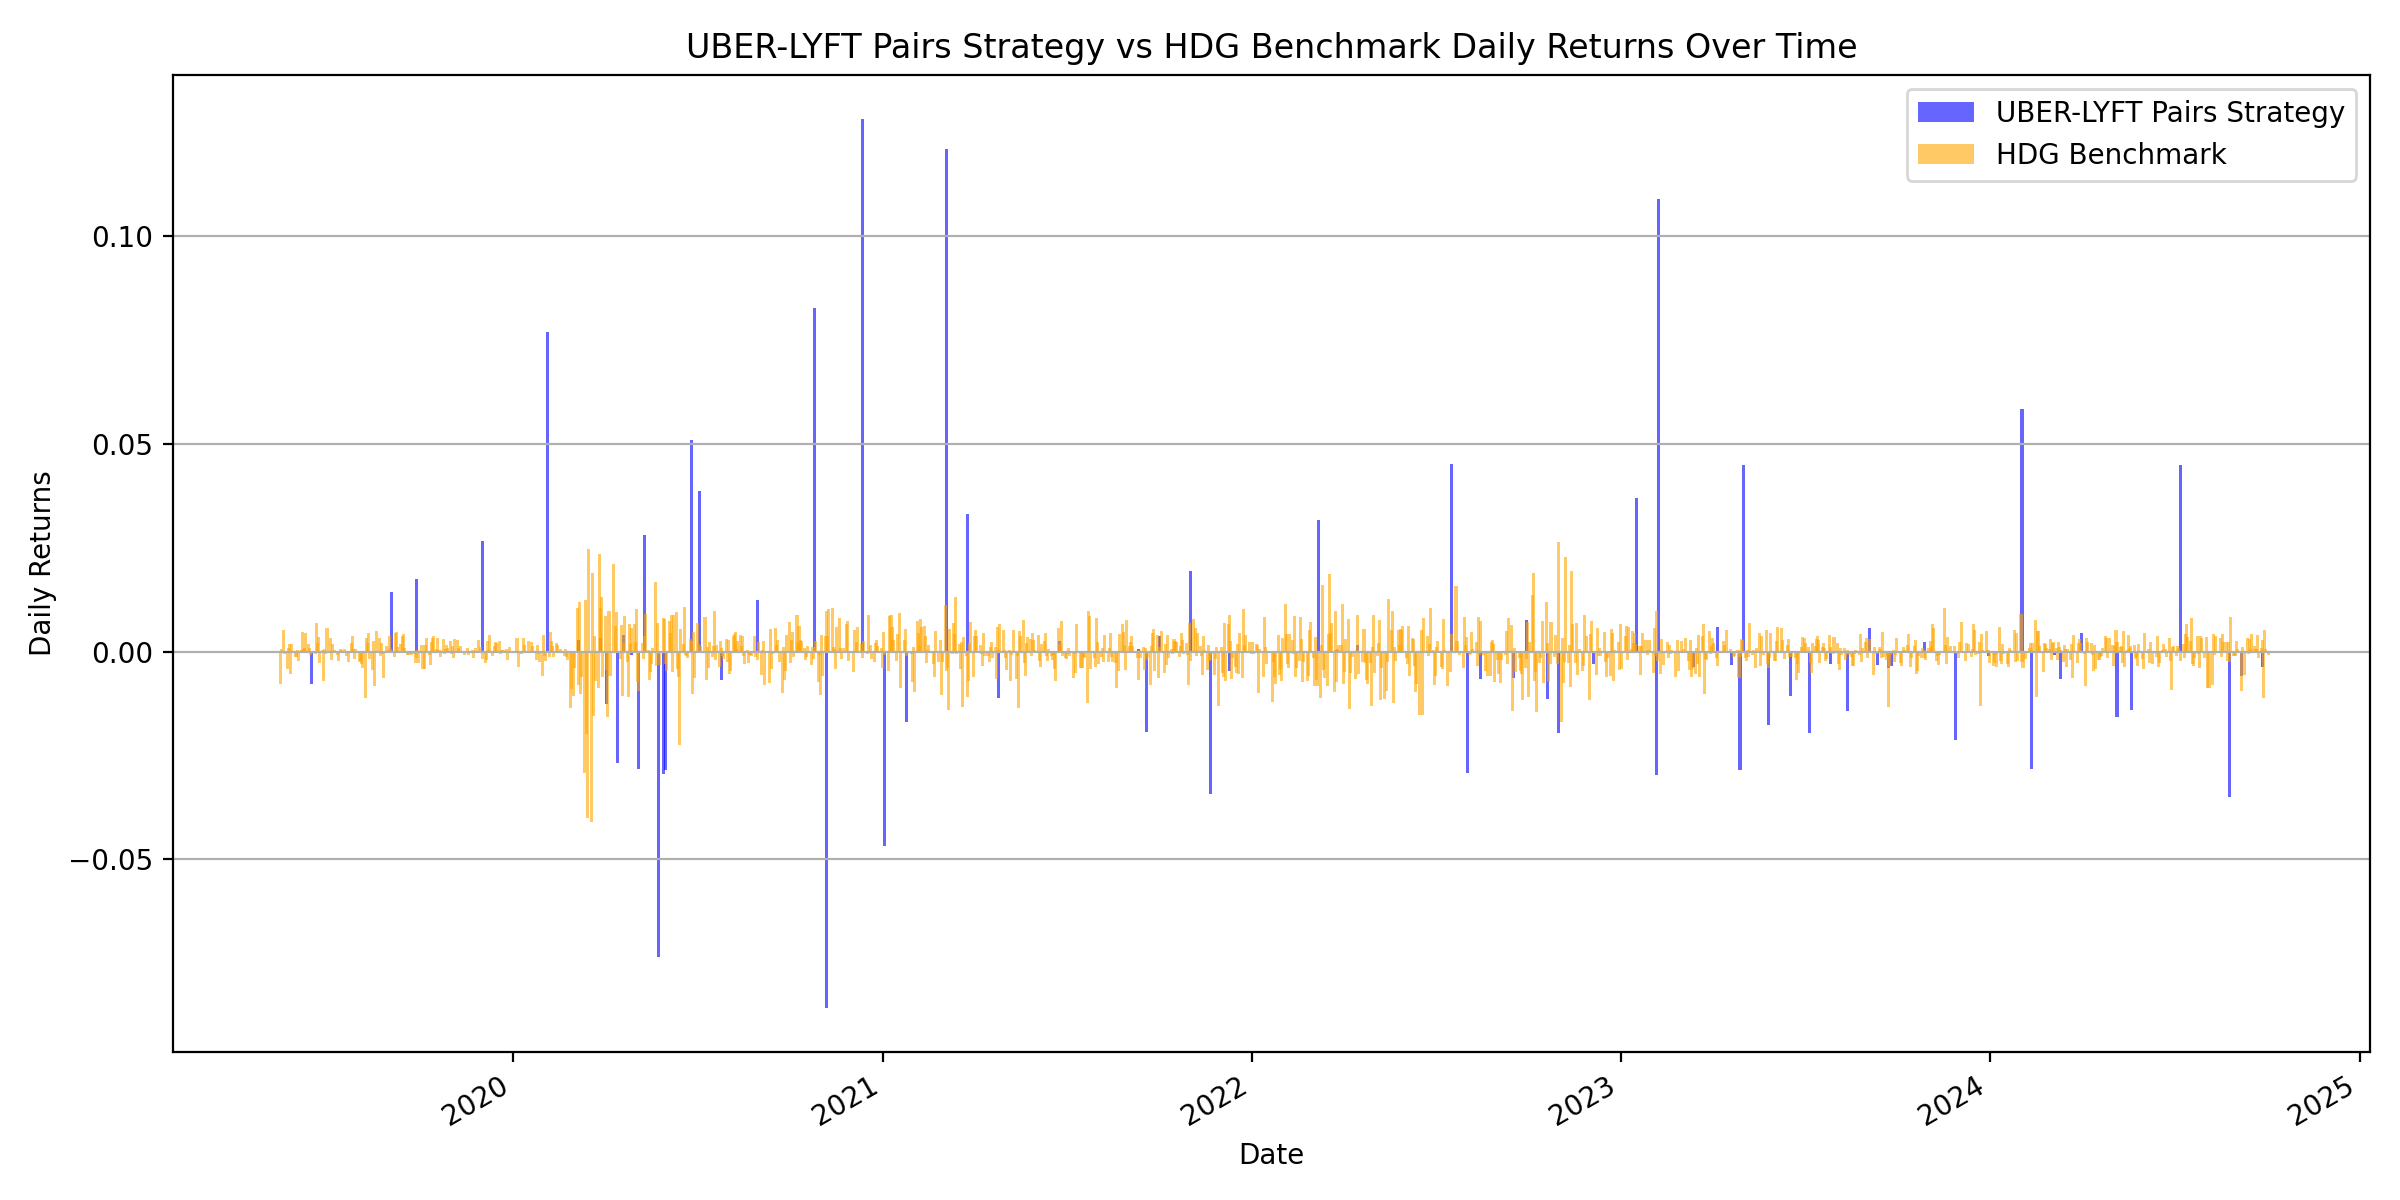

In [44]:
periodic_returns_L = periodic_returns_L.reindex(best_U_L.index)

# Convert 'date' column to datetime if not already
best_U_L['date'] = pd.to_datetime(best_U_L['date'])

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Bar width
bar_width = 3 # Width of each bar

# Bar chart for periodic_returns_L
ax.bar(best_U_L['date'] - pd.Timedelta(days=3), periodic_returns_L, width=bar_width, label='UBER-LYFT Pairs Strategy', color='blue', alpha=0.6)

# Bar chart for HDG_return
ax.bar(best_U_L['date'] + pd.Timedelta(days=3), best_U_L['HDG_return'], width=bar_width, label='HDG Benchmark', color='orange', alpha=0.6)

# Set date formatting for x-axis
ax.set_title('UBER-LYFT Pairs Strategy vs HDG Benchmark Daily Returns Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Returns')
ax.legend()
ax.grid(True, axis='y')

# Rotate and format x-axis labels
plt.gcf().autofmt_xdate()
plt.tight_layout()

plt.show()

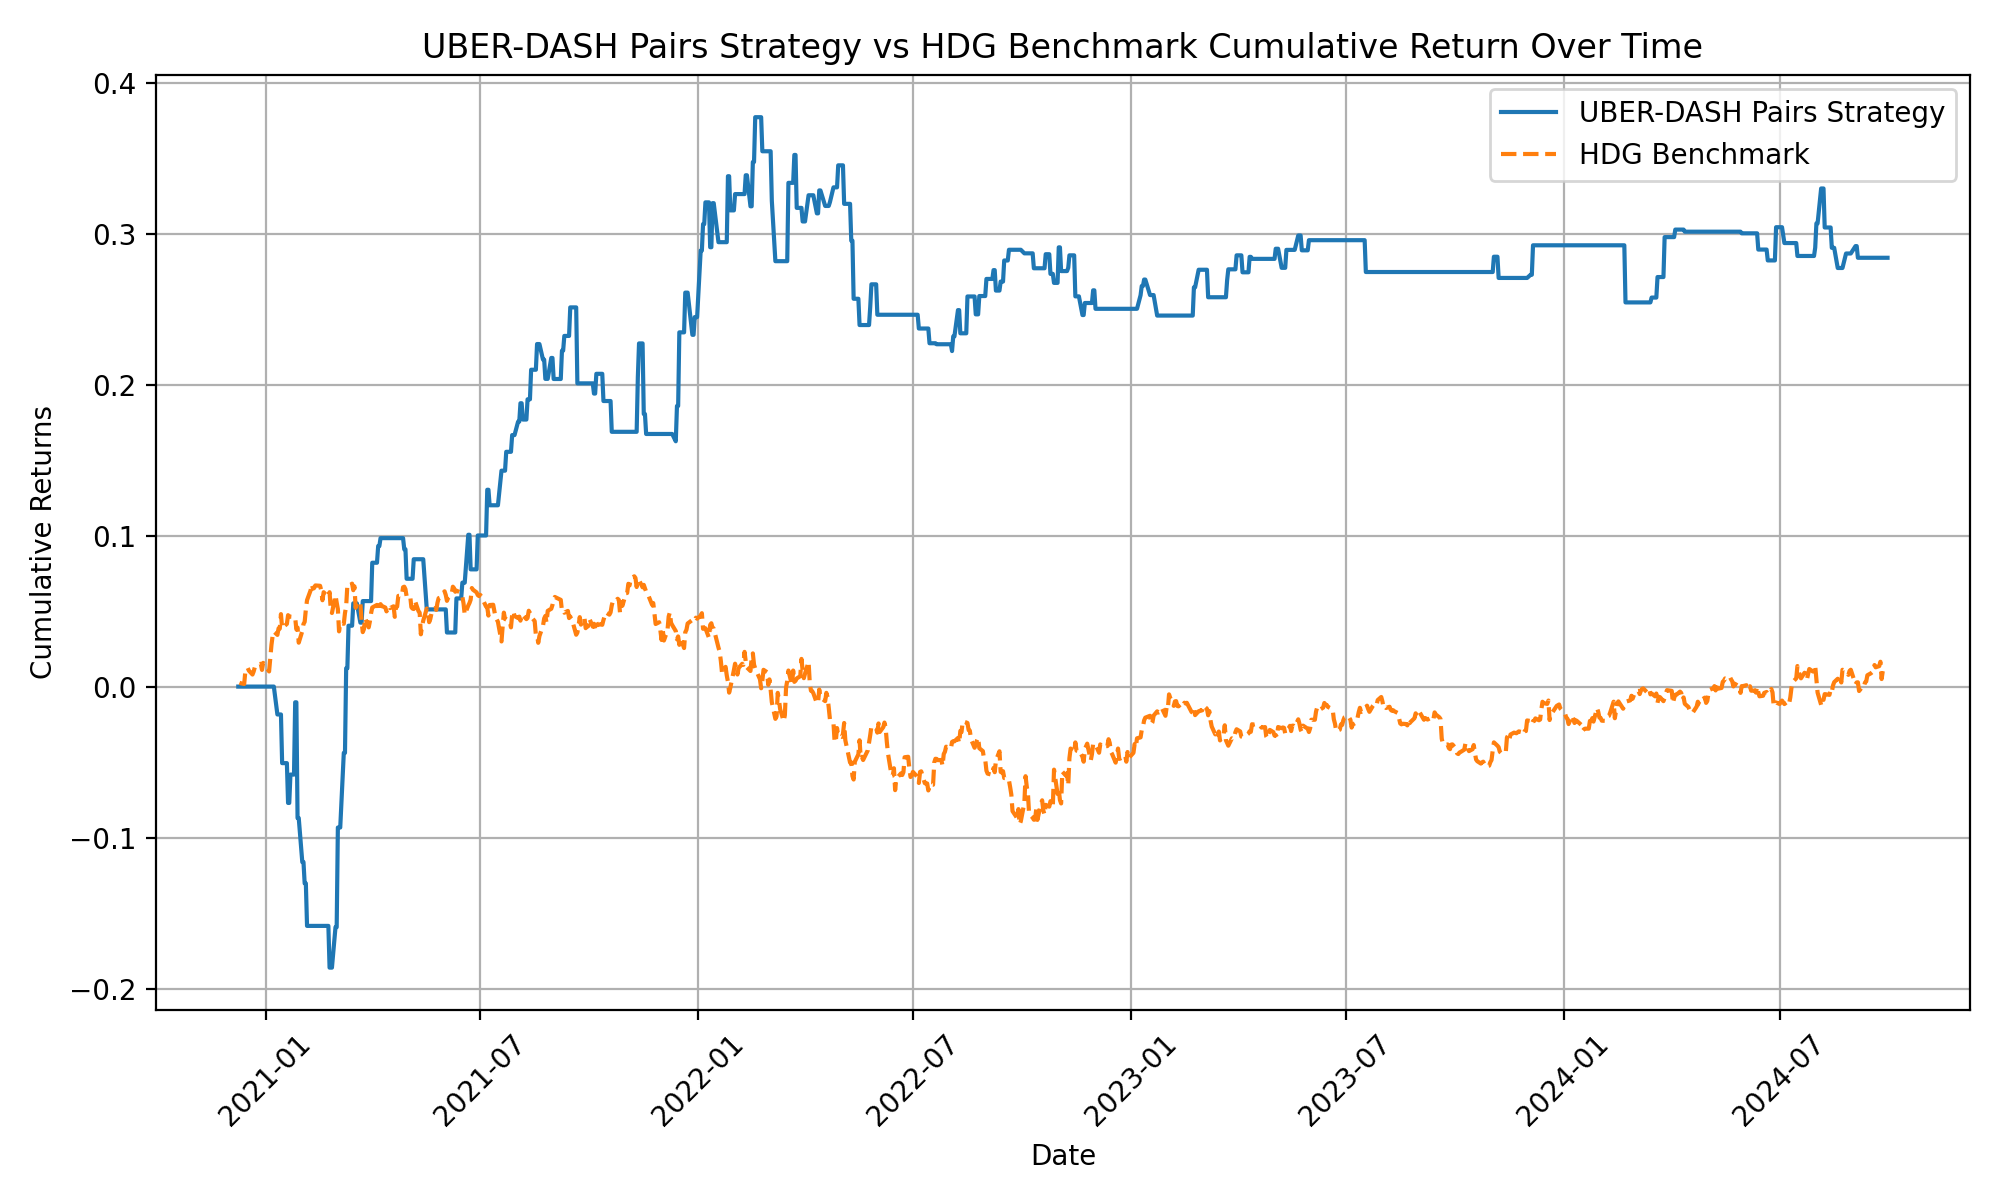

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(best_U_D['date'], best_U_D['return'], label='UBER-DASH Pairs Strategy')
plt.plot(best_U_D['date'], best_U_D['HDG_cum_return'], label='HDG Benchmark', linestyle='--')
plt.title('UBER-DASH Pairs Strategy vs HDG Benchmark Cumulative Return Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

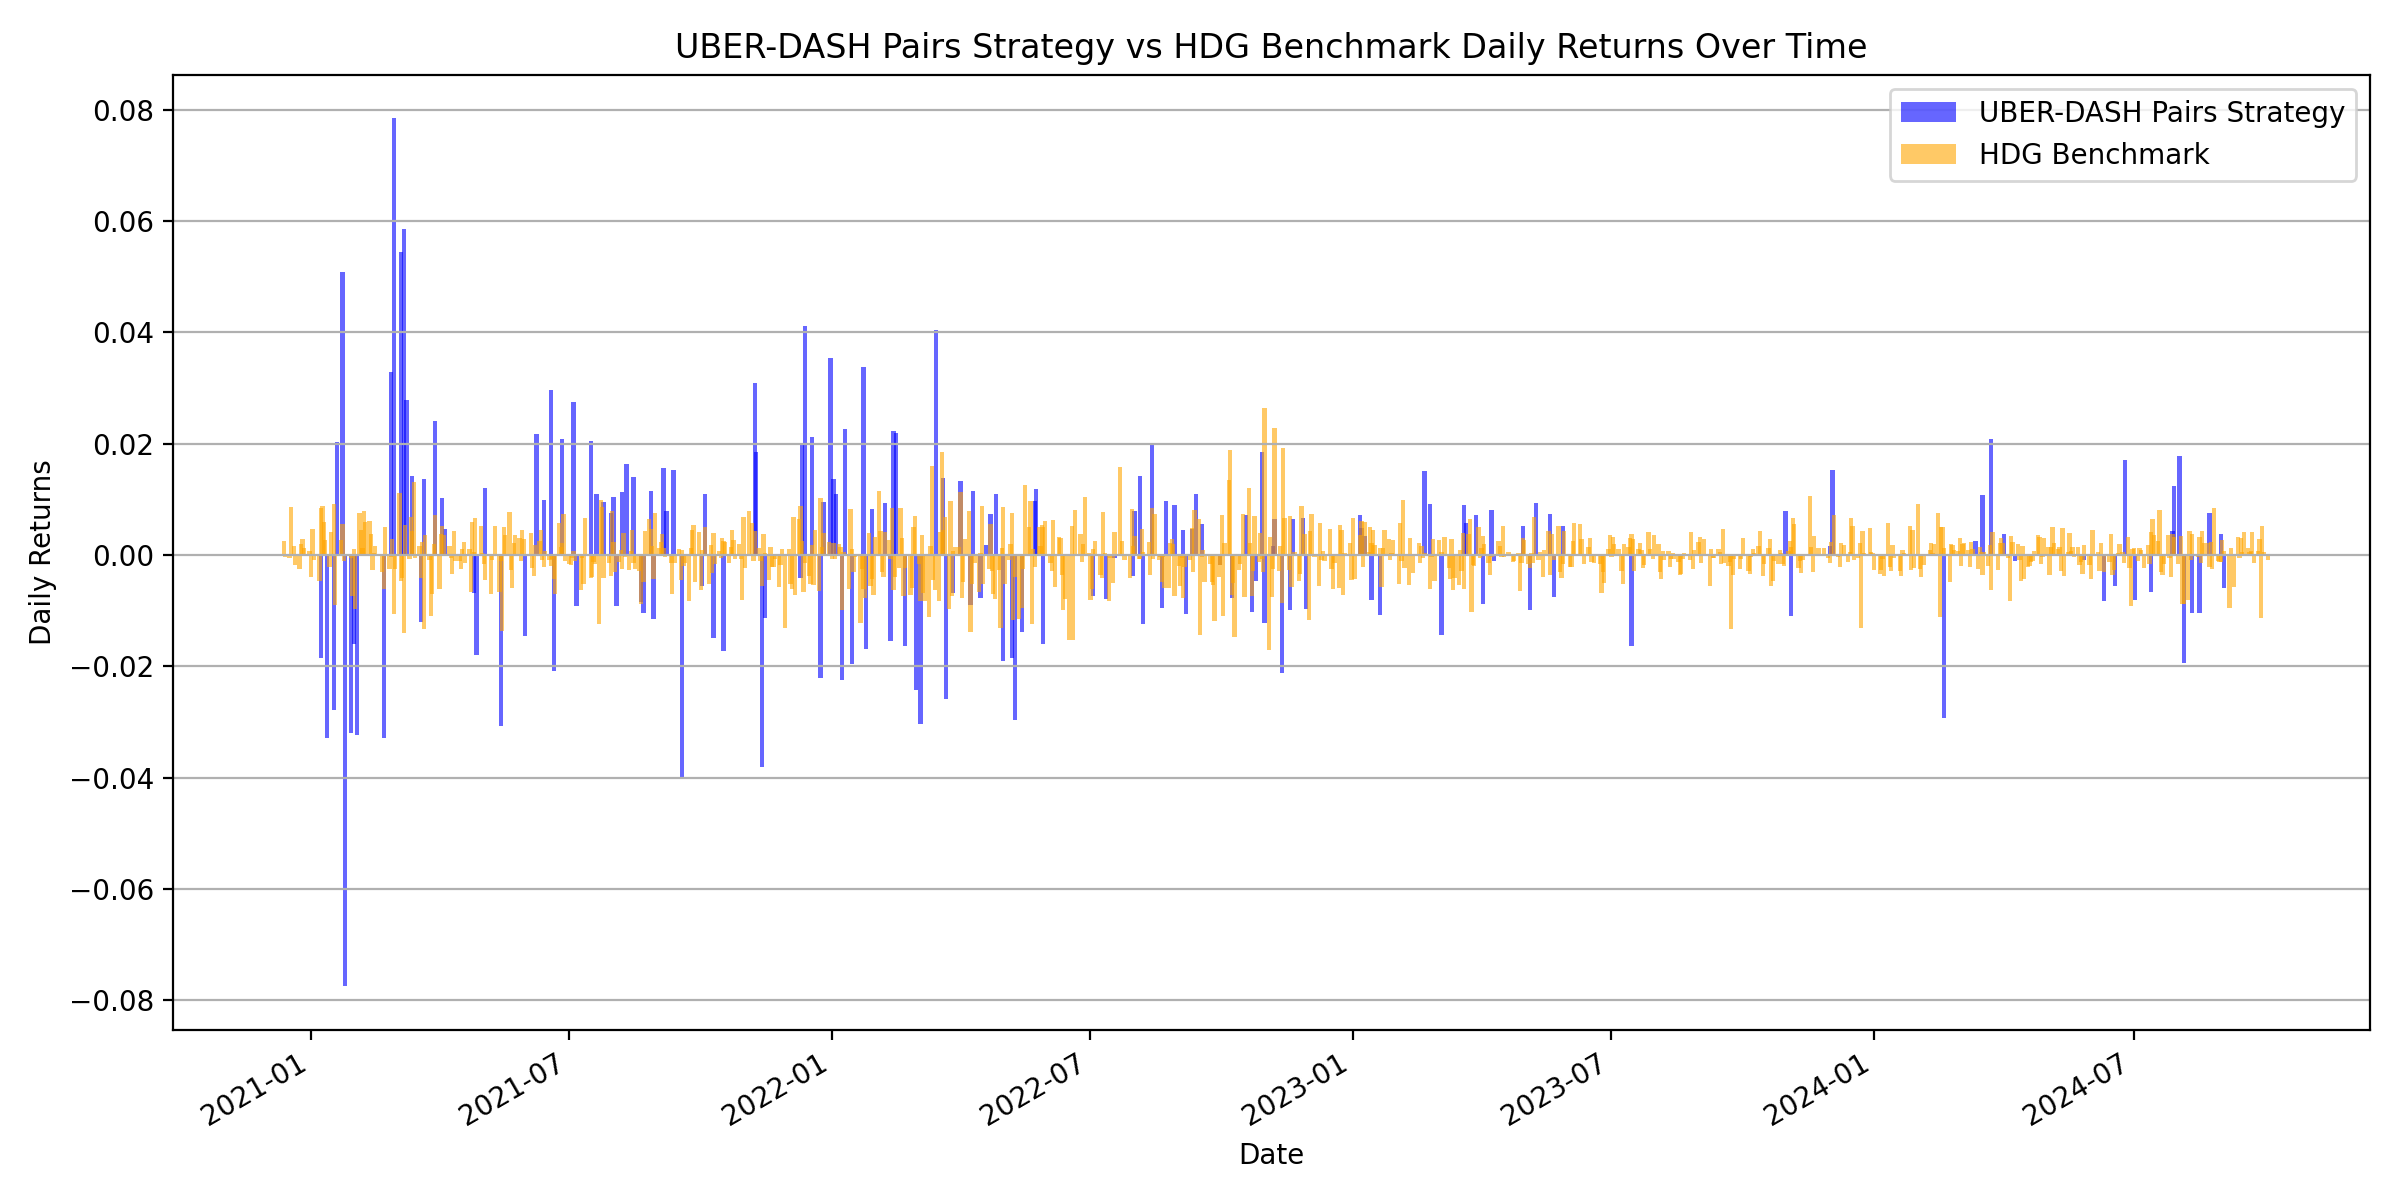

In [46]:
periodic_returns_D = periodic_returns_D.reindex(best_U_D.index)

# Convert 'date' column to datetime if not already
best_U_D['date'] = pd.to_datetime(best_U_D['date'])

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Bar width
bar_width = 3 # Width of each bar

# Bar chart for periodic_returns_L
ax.bar(best_U_D['date'] - pd.Timedelta(days=3), periodic_returns_D, width=bar_width, label='UBER-DASH Pairs Strategy', color='blue', alpha=0.6)

# Bar chart for HDG_return
ax.bar(best_U_D['date'] + pd.Timedelta(days=3), best_U_D['HDG_return'], width=bar_width, label='HDG Benchmark', color='orange', alpha=0.6)

# Set date formatting for x-axis
ax.set_title('UBER-DASH Pairs Strategy vs HDG Benchmark Daily Returns Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Returns')
ax.legend()
ax.grid(True, axis='y')

# Rotate and format x-axis labels
plt.gcf().autofmt_xdate()
plt.tight_layout()

plt.show()

We can get a clearer visual of when the outperformance begins and the higher variance in our strategy compared to the benchmark.